# Deep transfer learning tutorial
This notebook contains two popular paradigms of transfer learning: **Finetune** and **Domain adaptation**.
Since most of the codes are shared by them, we show how they work in just one single notebook.
I think that transfer learning and domain adaptation are both easy, and there's no need to create some library or packages for this simple purpose, which only makes things difficult.
The purpose of this note book is we **don't even need to install a library or package** to train a domain adaptation or finetune model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Some imports.

In [1]:
import os
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import time
from torchvision import models
torch.cuda.set_device(0)

In [2]:
# !pip install torch
# !pip install torchvision


In [3]:
print(torch.cuda.is_available())

True


Set the dataset folder, batch size, number of classes, and domain name.

In [4]:
data_folder = '/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/Z. RA & Desertation/Codes/Dr_Niu/MMD/Office31'
data_to_save_folder = '/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/Z. RA & Desertation/Codes/Dr_Niu/MMD/MMD_Result_not_trained_resnet'
batch_size = 32
n_class = 31
domain_src, domain_tar = 'amazon/images', 'dslr/images'

## Data load
Now, define a data loader function.

In [5]:
def load_data(root_path, domain, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}
    data = datasets.ImageFolder(root=os.path.join(root_path, domain), transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=phase=='src', drop_last=phase=='tar', num_workers=4)
    return data_loader

Load the data using the above function to test it.

In [6]:
src_loader = load_data(data_folder, domain_src, batch_size, phase='src')
tar_loader = load_data(data_folder, domain_tar, batch_size, phase='tar')
print(f'Source data number: {len(src_loader.dataset)}')
print(f'Target data number: {len(tar_loader.dataset)}')

Source data number: 2817
Target data number: 498


In [7]:
class TransferModel(nn.Module):
    def __init__(self,
                base_model : str = 'resnet50',
                pretrain : bool = True,
                n_class : int = 31):
        super(TransferModel, self).__init__()
        self.base_model = base_model
        self.pretrain = pretrain
        self.n_class = n_class
        if self.base_model == 'resnet50':
            self.model = torchvision.models.resnet50(pretrained=False)
            n_features = self.model.fc.in_features
            fc = torch.nn.Linear(n_features, n_class)
            self.model.fc = fc
        else:
            # Use other models you like, such as vgg or alexnet
            pass
        self.model.fc.weight.data.normal_(0, 0.005)
        self.model.fc.bias.data.fill_(0.1)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

Now, we define a model and test it using a random tensor.

In [8]:
model = TransferModel().cuda()
RAND_TENSOR = torch.randn(1, 3, 224, 224).cuda()
output = model(RAND_TENSOR)
print(output)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor([[ 0.4762,  0.2442,  0.2497,  0.4767,  0.1454, -0.0820, -0.4138, -0.0137,
          0.2863,  0.1532,  0.3225,  0.0412,  0.1346, -0.4132,  0.0563, -0.0318,
         -0.3439,  0.0043,  0.3873,  0.1513, -0.0608, -0.1170,  0.3066, -0.0047,
          0.1945, -0.1755,  0.3816,  0.2690,  0.1122,  0.3525,  0.3223]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 31])


In [9]:
dataloaders = {'src': src_loader,
               'val': tar_loader,
               'tar': tar_loader}
n_epoch = 100
criterion = nn.CrossEntropyLoss()
early_stop = 20

In [10]:
def test(model, target_test_loader):
    model.eval()
    correct = 0
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.cuda(), target.cuda()
            s_output = model.predict(data)
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = correct.double() / len(target_test_loader.dataset)
    return acc

## Domain adaptation
Now we are in domain adaptation.

## Logic for domain adaptation
The logic for domain adaptation is mostly similar to finetune, except that we must add a loss to the finetune model to **regularize the distribution discrepancy** between two domains.
Therefore, the most different parts are:
- Define some **loss function** to compute the distance (which is the main contribution of most existing DA papers)
- Define a new model class to use that loss function for **forward** pass.
- Write a slightly different script to train, since we have to take both **source data, source label, and target data**.

### Loss function
The most popular loss function for DA is **MMD (Maximum Mean Discrepancy)**. For comaprison, we also use another popular loss **CORAL (CORrelation ALignment)**. They are defined as follows.

#### MMD loss

In [11]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss


#### CORAL loss

In [ ]:
def CORAL(source, target):
    d = source.size(1)
    ns, nt = source.size(0), target.size(0)

    # source covariance
    tmp_s = torch.ones((1, ns)).cuda() @ source
    cs = (source.t() @ source - (tmp_s.t() @ tmp_s) / ns) / (ns - 1)

    # target covariance
    tmp_t = torch.ones((1, nt)).cuda() @ target
    ct = (target.t() @ target - (tmp_t.t() @ tmp_t) / nt) / (nt - 1)

    # frobenius norm
    loss = (cs - ct).pow(2).sum().sqrt()
    loss = loss / (4 * d * d)

    return loss

### Model
Now we use ResNet-50 again just like finetune. The difference is that we rewrite the ResNet-50 class to drop its last layer.

In [12]:
from torchvision import models
class ResNet50Fc(nn.Module):
    def __init__(self):
        super(ResNet50Fc, self).__init__()
        model_resnet50 = models.resnet50(pretrained=False)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.__in_features = model_resnet50.fc.in_features

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features

In [13]:
# Function to visualize the convolutional kernels
def visualize_kernels(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            kernels = module.weight.data.cpu().numpy()
            num_kernels = kernels.shape[0]
            fig, axs = plt.subplots(1, num_kernels, figsize=(10, 2))
            for i in range(num_kernels):
                kernel = kernels[i, 0, :, :]
                axs[i].imshow(kernel, cmap='gray')
                axs[i].axis('off')
            plt.show()

# Function to compute the entropy of convolutional layers
def compute_entropy(model):
    entropy_values = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            weights = module.weight.data
            flattened_weights = weights.flatten()
#             normalized_weights = torch.softmax(flattened_weights, dim=1)
#             entropy = -torch.sum(normalized_weights * torch.log2(normalized_weights + 1e-10), dim=1)
            normalized_weights = (flattened_weights - torch.min(flattened_weights)) / (
                torch.max(flattened_weights) - torch.min(flattened_weights)
            )
            bin_counts = torch.histc(normalized_weights, bins=10)
            probabilities = bin_counts / len(flattened_weights)
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10))  # Add a small constant to avoid log(0)
            entropy_values.append(torch.mean(entropy).item())
    return entropy_values

# Function to add noise to an image
def add_noise(image, noise_level):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return noisy_image

Now the main class for DA. We take ResNet-50 as its backbone, add a bottleneck layer and our own FC layer for classification.
Note the `adapt_loss` function. It is just using our predefined MMD or CORAL loss. Of course you can use your own loss.

In [14]:
class TransferNet(nn.Module):
    def __init__(self,
                 num_class,
                 base_net='resnet50',
                 transfer_loss='mmd',
                 use_bottleneck=True,
                 bottleneck_width=256,
                 width=1024):
        super(TransferNet, self).__init__()
        if base_net == 'resnet50':
            self.base_network = ResNet50Fc()
        else:
            # Your own basenet
            return
        self.use_bottleneck = use_bottleneck
        self.transfer_loss = transfer_loss
        bottleneck_list = [nn.Linear(self.base_network.output_num(
        ), bottleneck_width), nn.BatchNorm1d(bottleneck_width), nn.ReLU(), nn.Dropout(0.5)]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)
        classifier_layer_list = [nn.Linear(self.base_network.output_num(), width), nn.ReLU(), nn.Dropout(0.5),
                                 nn.Linear(width, num_class)]
        self.classifier_layer = nn.Sequential(*classifier_layer_list)

        self.bottleneck_layer[0].weight.data.normal_(0, 0.005)
        self.bottleneck_layer[0].bias.data.fill_(0.1)
        for i in range(2):
            self.classifier_layer[i * 3].weight.data.normal_(0, 0.01)
            self.classifier_layer[i * 3].bias.data.fill_(0.0)

    def forward(self, source, target):
        source = self.base_network(source)
        target = self.base_network(target)
        source_clf = self.classifier_layer(source)
        if self.use_bottleneck:
            source = self.bottleneck_layer(source)
            target = self.bottleneck_layer(target)
        transfer_loss = self.adapt_loss(source, target, self.transfer_loss)
        return source_clf, transfer_loss

    def predict(self, x):
        features = self.base_network(x)
        clf = self.classifier_layer(features)
        return clf

    def adapt_loss(self, X, Y, adapt_loss):
        """Compute adaptation loss, currently we support mmd and coral

        Arguments:
            X {tensor} -- source matrix
            Y {tensor} -- target matrix
            adapt_loss {string} -- loss type, 'mmd' or 'coral'. You can add your own loss

        Returns:
            [tensor] -- adaptation loss tensor
        """
        if adapt_loss == 'mmd':
            mmd_loss = MMD_loss()
            loss = mmd_loss(X, Y)
        elif adapt_loss == 'coral':
            loss = CORAL(X, Y)
        else:
            # Your own loss
            loss = 0
        return loss

### Train
Now the train part.

In [15]:
transfer_loss = 'mmd'
learning_rate = 0.0001
transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# lamb = 0.5 # weight for transfer loss, it is a hyperparameter that needs to be tuned

The main train function. Since we have to enumerate all source and target samples, we have to use `zip` operation to enumerate each pair of these two domains. It is common that two domains have different sizes, but we think by randomly sampling them in many epochs, we may sample each one of them.

In [16]:
def train(dataloaders, model, optimizer):
    source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['val'], dataloaders['tar']
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    n_batch = min(len_source_loader, len_target_loader)
    for e in range(n_epoch):
        stop += 1
        train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
        model.train()
        for (src, tar) in zip(source_loader, target_train_loader):
            data_source, label_source = src
            data_target, _ = tar
            data_source, label_source = data_source.cuda(), label_source.cuda()
            data_target = data_target.cuda()

            optimizer.zero_grad()
            label_source_pred, transfer_loss = model(data_source, data_target)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss
            loss.backward()
            optimizer.step()
            train_loss_clf = clf_loss.detach().item() + train_loss_clf
            train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
            train_loss_total = loss.detach().item() + train_loss_total
        acc = test(model, target_test_loader)
        print(f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')

        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), 'trans_model.pkl')
            stop = 0
        if stop >= early_stop:
            break

In [ ]:
# train(dataloaders, transfer_model, optimizer)

In [ ]:
# transfer_model.load_state_dict(torch.load('trans_model.pkl'))
# acc_test = test(transfer_model, dataloaders['tar'])
# print(f'Test accuracy: {acc_test}')

Now we are done.

You see, we don't even need to install a library or package to train a domain adaptation or finetune model.
In your own work, you can also use this notebook to test your own algorithms.

Add entropy

# Archive


In [17]:
transfer_loss = 'mmd'
learning_rate = 0.0001
transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# lamb = 0.5 # weight for transfer loss, it is a hyperparameter that needs to be tuned

train_result = pd.DataFrame() # new added
test_result = pd.DataFrame()
def train2(dataloaders, model, optimizer, lamb):
    source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['val'], dataloaders['tar']
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    n_batch = min(len_source_loader, len_target_loader)
    records = [] # new added
    for e in range(n_epoch):
        stop += 1
        train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
        model.train()
        for (src, tar) in zip(source_loader, target_train_loader):
            data_source, label_source = src
            data_target, _ = tar
            data_source, label_source = data_source.cuda(), label_source.cuda()
            data_target = data_target.cuda()

            optimizer.zero_grad()
            label_source_pred, transfer_loss = model(data_source, data_target)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss
            loss.backward()
            optimizer.step()
            train_loss_clf = clf_loss.detach().item() + train_loss_clf
            train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
            train_loss_total = loss.detach().item() + train_loss_total
        acc = test(model, target_test_loader)
        print(f'lambda= {lamb}',f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')
        records.append({ # new added
            'Lambda': lamb,
            'Epoch': e,
            'Cls_Loss': train_loss_clf/n_batch,
            'Transfer_Loss': train_loss_transfer/n_batch,
            'Total_Loss': train_loss_total/n_batch,
            'Accuracy': acc
        })

        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), 'trans_model.pkl')
            stop = 0
        if stop >= early_stop:
            break

    global train_result
    train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


In [18]:
def test2(model, target_test_loader):
    records = [] # new added
    model.eval()
    correct = 0
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.cuda(), target.cuda()
            s_output = model.predict(data)
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = correct.double() / len(target_test_loader.dataset)
    records.append({ # new added
            'Lambda': lamb,
            'Test accuracy': acc,
    })
    global test_result
    test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
    return acc

In [19]:
import numpy as np
test_result = pd.DataFrame(columns=["lambda", "Test accuracy"])
train_result = pd.DataFrame()
test_result = pd.DataFrame()

import gc
train_result = pd.DataFrame() # new added
test_result = pd.DataFrame()
for lamb in np.arange(0, 0.5, 0.10).round(1):
    transfer_loss = 'mmd'
    learning_rate = 0.0001
    transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
    optimizer = torch.optim.SGD([
        {'params': transfer_model.base_network.parameters()},
        {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
        {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
    ], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    # lamb = 0.5 # weight for transfer loss, it is a hyperparameter that needs to be tuned

    # train_result = pd.DataFrame() # new added
    # test_result = pd.DataFrame()
    def train2(dataloaders, model, optimizer, lamb):
        source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['val'], dataloaders['tar']
        len_source_loader = len(source_loader)
        len_target_loader = len(target_train_loader)
        best_acc = 0
        stop = 0
        n_batch = min(len_source_loader, len_target_loader)
        records = [] # new added
        for e in range(n_epoch):
            stop += 1
            train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
            model.train()
            for (src, tar) in zip(source_loader, target_train_loader):
                data_source, label_source = src
                data_target, _ = tar
                data_source, label_source = data_source.cuda(), label_source.cuda()
                data_target = data_target.cuda()

                optimizer.zero_grad()
                label_source_pred, transfer_loss = model(data_source, data_target)
                clf_loss = criterion(label_source_pred, label_source)
                loss = clf_loss + lamb * transfer_loss
                loss.backward()
                optimizer.step()
                train_loss_clf = clf_loss.detach().item() + train_loss_clf
                train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
                train_loss_total = loss.detach().item() + train_loss_total
            acc = test(model, target_test_loader)
            print(f'lambda= {lamb}',f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')
            records.append({ # new added
                'Lambda': lamb,
                'Epoch': e,
                'Cls_Loss': train_loss_clf/n_batch,
                'Transfer_Loss': train_loss_transfer/n_batch,
                'Total_Loss': train_loss_total/n_batch,
                'Accuracy': acc
            })

            if best_acc < acc:
                best_acc = acc
                torch.save(model.state_dict(), 'trans_model.pkl')
                stop = 0
            if stop >= early_stop:
                break

        global train_result
        train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
        train_result.to_csv(os.path.join(data_folder, f'train_result_amazon_dslr_resnet50_lambda {lamb}.csv'), index=False)

    train2(dataloaders, transfer_model, optimizer, lamb.round(1))
    transfer_model.load_state_dict(torch.load('trans_model.pkl'))
    acc_test = test(transfer_model, dataloaders['tar'])
    print(f'lambda= {lamb}', f'Test accuracy: {acc_test}')
    del transfer_model
    # del train2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lambda= 0.0 Epoch: [ 0/100], cls_loss: 3.4380, transfer_loss: 0.1844, total_Loss: 3.4380, acc: 0.0241
lambda= 0.0 Epoch: [ 1/100], cls_loss: 3.4326, transfer_loss: 0.1737, total_Loss: 3.4326, acc: 0.0622
lambda= 0.0 Epoch: [ 2/100], cls_loss: 3.4068, transfer_loss: 0.1722, total_Loss: 3.4068, acc: 0.0181
lambda= 0.0 Epoch: [ 3/100], cls_loss: 3.4231, transfer_loss: 0.1635, total_Loss: 3.4231, acc: 0.0462
lambda= 0.0 Epoch: [ 4/100], cls_loss: 3.3979, transfer_loss: 0.1680, total_Loss: 3.3979, acc: 0.0522
lambda= 0.0 Epoch: [ 5/100], cls_loss: 3.3948, transfer_loss: 0.1642, total_Loss: 3.3948, acc: 0.0241
lambda= 0.0 Epoch: [ 6/100], cls_loss: 3.4001, transfer_loss: 0.1663, total_Loss: 3.4001, acc: 0.0201
lambda= 0.0 Epoch: [ 7/100], cls_loss: 3.3957, transfer_loss: 0.1722, total_Loss: 3.3957, acc: 0.0462
lambda= 0.0 Epoch: [ 8/100], cls_loss: 3.3804, transfer_loss: 0.1726, total_Loss: 3.3804, acc: 0.0361
lambda= 0.0 Epoch: [ 9/100], cls_loss: 3.3781, transfer_loss: 0.1824, total_Loss: 

<ipython-input-19-72365ad5209e>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.0 Test accuracy: 0.0642570281124498


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lambda= 0.1 Epoch: [ 0/100], cls_loss: 3.4312, transfer_loss: 0.1618, total_Loss: 3.4474, acc: 0.0201
lambda= 0.1 Epoch: [ 1/100], cls_loss: 3.4489, transfer_loss: 0.1651, total_Loss: 3.4654, acc: 0.0321
lambda= 0.1 Epoch: [ 2/100], cls_loss: 3.4140, transfer_loss: 0.1569, total_Loss: 3.4297, acc: 0.0422
lambda= 0.1 Epoch: [ 3/100], cls_loss: 3.4240, transfer_loss: 0.1561, total_Loss: 3.4396, acc: 0.0422
lambda= 0.1 Epoch: [ 4/100], cls_loss: 3.4086, transfer_loss: 0.1695, total_Loss: 3.4255, acc: 0.0542
lambda= 0.1 Epoch: [ 5/100], cls_loss: 3.4099, transfer_loss: 0.1514, total_Loss: 3.4250, acc: 0.0442
lambda= 0.1 Epoch: [ 6/100], cls_loss: 3.3903, transfer_loss: 0.1614, total_Loss: 3.4064, acc: 0.0582
lambda= 0.1 Epoch: [ 7/100], cls_loss: 3.3888, transfer_loss: 0.1670, total_Loss: 3.4055, acc: 0.0341
lambda= 0.1 Epoch: [ 8/100], cls_loss: 3.3958, transfer_loss: 0.1533, total_Loss: 3.4111, acc: 0.0542
lambda= 0.1 Epoch: [ 9/100], cls_loss: 3.4025, transfer_loss: 0.1536, total_Loss: 

<ipython-input-19-72365ad5209e>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.1 Test accuracy: 0.058232931726907626


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lambda= 0.2 Epoch: [ 0/100], cls_loss: 3.4508, transfer_loss: 0.1560, total_Loss: 3.4821, acc: 0.0482
lambda= 0.2 Epoch: [ 1/100], cls_loss: 3.4325, transfer_loss: 0.1724, total_Loss: 3.4670, acc: 0.0482
lambda= 0.2 Epoch: [ 2/100], cls_loss: 3.4332, transfer_loss: 0.1538, total_Loss: 3.4639, acc: 0.0482
lambda= 0.2 Epoch: [ 3/100], cls_loss: 3.4163, transfer_loss: 0.1510, total_Loss: 3.4465, acc: 0.0141
lambda= 0.2 Epoch: [ 4/100], cls_loss: 3.4039, transfer_loss: 0.1544, total_Loss: 3.4348, acc: 0.0301
lambda= 0.2 Epoch: [ 5/100], cls_loss: 3.3858, transfer_loss: 0.1675, total_Loss: 3.4193, acc: 0.0181
lambda= 0.2 Epoch: [ 6/100], cls_loss: 3.3995, transfer_loss: 0.1584, total_Loss: 3.4311, acc: 0.0241
lambda= 0.2 Epoch: [ 7/100], cls_loss: 3.4141, transfer_loss: 0.1541, total_Loss: 3.4449, acc: 0.0482
lambda= 0.2 Epoch: [ 8/100], cls_loss: 3.4110, transfer_loss: 0.1764, total_Loss: 3.4463, acc: 0.0201
lambda= 0.2 Epoch: [ 9/100], cls_loss: 3.3919, transfer_loss: 0.1518, total_Loss: 

<ipython-input-19-72365ad5209e>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.2 Test accuracy: 0.0682730923694779


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lambda= 0.3 Epoch: [ 0/100], cls_loss: 3.4333, transfer_loss: 0.1540, total_Loss: 3.4795, acc: 0.0201
lambda= 0.3 Epoch: [ 1/100], cls_loss: 3.4231, transfer_loss: 0.1550, total_Loss: 3.4696, acc: 0.0301
lambda= 0.3 Epoch: [ 2/100], cls_loss: 3.4266, transfer_loss: 0.1618, total_Loss: 3.4751, acc: 0.0622
lambda= 0.3 Epoch: [ 3/100], cls_loss: 3.4073, transfer_loss: 0.1527, total_Loss: 3.4531, acc: 0.0602
lambda= 0.3 Epoch: [ 4/100], cls_loss: 3.4069, transfer_loss: 0.1544, total_Loss: 3.4532, acc: 0.0241
lambda= 0.3 Epoch: [ 5/100], cls_loss: 3.4170, transfer_loss: 0.1466, total_Loss: 3.4610, acc: 0.0241
lambda= 0.3 Epoch: [ 6/100], cls_loss: 3.4107, transfer_loss: 0.1479, total_Loss: 3.4551, acc: 0.0562
lambda= 0.3 Epoch: [ 7/100], cls_loss: 3.4046, transfer_loss: 0.1365, total_Loss: 3.4456, acc: 0.0663
lambda= 0.3 Epoch: [ 8/100], cls_loss: 3.4195, transfer_loss: 0.1403, total_Loss: 3.4615, acc: 0.0261
lambda= 0.3 Epoch: [ 9/100], cls_loss: 3.3872, transfer_loss: 0.1324, total_Loss: 

<ipython-input-19-72365ad5209e>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.3 Test accuracy: 0.06626506024096385


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lambda= 0.4 Epoch: [ 0/100], cls_loss: 3.4298, transfer_loss: 0.1664, total_Loss: 3.4964, acc: 0.0361
lambda= 0.4 Epoch: [ 1/100], cls_loss: 3.4142, transfer_loss: 0.1666, total_Loss: 3.4808, acc: 0.0301
lambda= 0.4 Epoch: [ 2/100], cls_loss: 3.4136, transfer_loss: 0.1705, total_Loss: 3.4818, acc: 0.0281
lambda= 0.4 Epoch: [ 3/100], cls_loss: 3.4036, transfer_loss: 0.1731, total_Loss: 3.4728, acc: 0.0301
lambda= 0.4 Epoch: [ 4/100], cls_loss: 3.4134, transfer_loss: 0.1484, total_Loss: 3.4727, acc: 0.0482
lambda= 0.4 Epoch: [ 5/100], cls_loss: 3.4113, transfer_loss: 0.1413, total_Loss: 3.4679, acc: 0.0261
lambda= 0.4 Epoch: [ 6/100], cls_loss: 3.4078, transfer_loss: 0.1500, total_Loss: 3.4678, acc: 0.0201
lambda= 0.4 Epoch: [ 7/100], cls_loss: 3.4054, transfer_loss: 0.1297, total_Loss: 3.4573, acc: 0.0281
lambda= 0.4 Epoch: [ 8/100], cls_loss: 3.4050, transfer_loss: 0.1243, total_Loss: 3.4547, acc: 0.0301
lambda= 0.4 Epoch: [ 9/100], cls_loss: 3.3736, transfer_loss: 0.1391, total_Loss: 

<ipython-input-19-72365ad5209e>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.4 Test accuracy: 0.06024096385542168


In [ ]:
# import numpy as np
# # test_result = pd.DataFrame(columns=["lambda", "Test accuracy"])
# train_result = pd.DataFrame()
# test_result = pd.DataFrame()
# import gc

# for lamb in np.arange(0, 1.1, 0.10).round(1):
#     # transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
#     train2(dataloaders, transfer_model, optimizer, lamb.round(1))
#     transfer_model.load_state_dict(torch.load('trans_model.pkl'))
#     acc_test = test2(transfer_model, dataloaders['tar'])
#     print(f'lambda= {lamb}', f'Test accuracy: {acc_test}')
#     # del transfer_model
#     # gc.collect()
#     # torch.cuda.empty_cache()
#     # test_result = test_result.append({"lambda": lamb, "Test accuracy": acc_test}, ignore_index=True)
# # [train2(dataloaders, transfer_model, optimizer, lamb.round(1)) for lamb in np.arange(0, 1, 0.10)]

In [ ]:
train_result.to_csv(os.path.join(data_to_save_folder, 'train_result_amazon_dslr_noPretrained_resnet50_3.csv'), index=False)
test_result.to_csv(os.path.join(data_to_save_folder, 'test_result_amazon_dslr_noPretrained_resnet50_3.csv'), index=False)

In [ ]:
import pandas as pd

df_result = pd.read_csv(os.path.join(data_folder, 'train_test_result.csv'))
df_result.head(1)


,Lambda,Epoch,Cls_Loss,Transfer_Loss,Total_Loss,Train_Accuracy,Test_Accuracy
0,0.0,0,0.944058,0.165341,0.944058,0.7119,0.750943


In [ ]:
df_result.groupby('Lambda')['Train_Accuracy'].max()

Lambda
0.0    0.7509
0.1    0.7509
0.2    0.7597
0.3    0.7547
0.4    0.7572
0.5    0.7497
0.6    0.7509
0.7    0.7597
0.8    0.7547
0.9    0.7522
Name: Train_Accuracy, dtype: float64

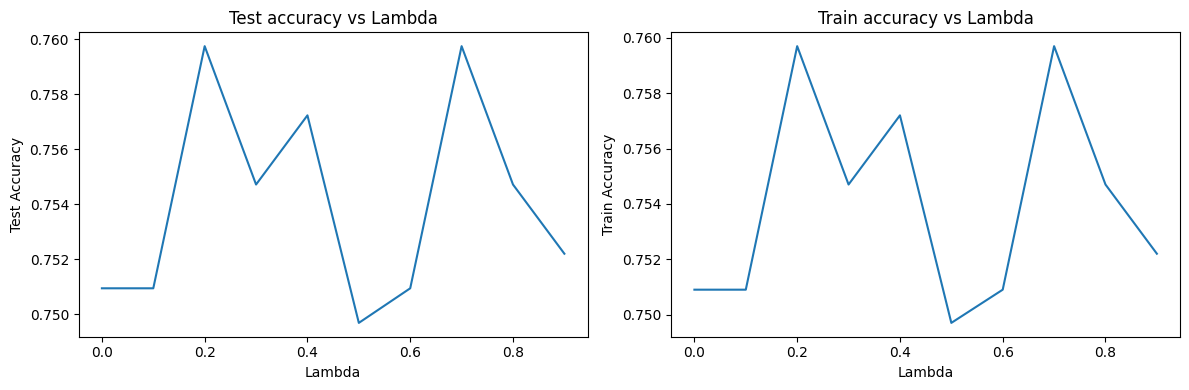

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df_result.Lambda, df_result.Test_Accuracy)
axes[0].set_title("Test accuracy vs Lambda")
axes[0].set_xlabel("Lambda")
axes[0].set_ylabel("Test Accuracy")

axes[1].plot(df_result.Lambda.unique(), df_result.groupby('Lambda')['Train_Accuracy'].max())
axes[1].set_title("Train accuracy vs Lambda")
axes[1].set_xlabel("Lambda")
axes[1].set_ylabel("Train Accuracy")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Test Accuracy')

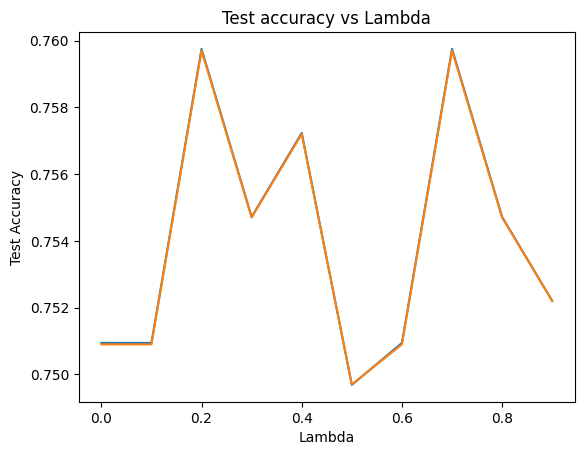

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_result.Lambda, df_result.Test_Accuracy)
plt.plot(df_result.Lambda.unique(), df_result.groupby('Lambda')['Train_Accuracy'].max())
plt.title("Test accuracy vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Test Accuracy")

Text(0, 0.5, 'Train_Accuracy_max')

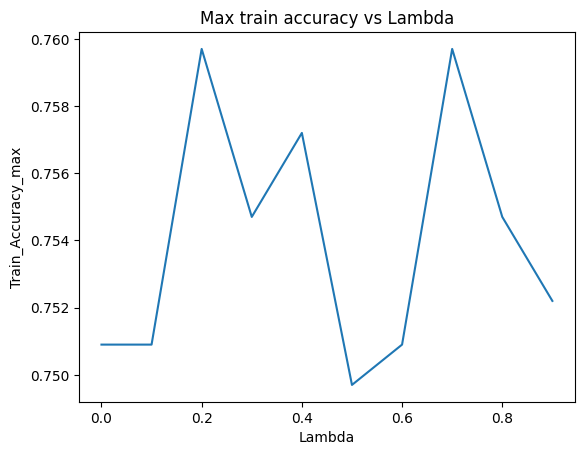

In [ ]:
import numpy as np
df_result['Train_Accuracy_max']=df_result.groupby('Lambda')['Train_Accuracy'].max()

df_result.head(1)
plt.plot(df_result.Lambda.unique(), df_result.groupby('Lambda')['Train_Accuracy'].max())
plt.title("Max train accuracy vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Train_Accuracy_max")

In [ ]:
df_result

,Lambda,Epoch,Cls_Loss,Transfer_Loss,Total_Loss,Train_Accuracy,Test_Accuracy,Train_Accuracy_max
0,0.0,0,0.944058,0.165341,0.944058,0.7119,0.750943,0.7509
1,0.0,1,0.978339,0.163392,0.978339,0.7396,0.750943,NaN
2,0.0,2,0.938446,0.162859,0.938446,0.7082,0.750943,NaN
3,0.0,3,0.969923,0.163086,0.969923,0.7082,0.750943,NaN
4,0.0,4,1.019977,0.164751,1.019977,0.6981,0.750943,NaN
...,...,...,...,...,...,...,...,...
305,0.9,58,0.390653,0.088210,0.470042,0.7509,0.752201,NaN
306,0.9,59,0.437389,0.087064,0.515746,0.7409,0.752201,NaN
307,0.9,60,0.393735,0.088516,0.473399,0.7421,0.752201,NaN
308,0.9,61,0.374819,0.085039,0.451354,0.7296,0.752201,NaN
